In [32]:
import logging
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pykeen
from pykeen.kge_models import TransE

In [33]:
%matplotlib inline

In [34]:
logging.basicConfig(level=logging.INFO)
logging.getLogger('pykeen').setLevel(logging.INFO)

In [35]:
print(sys.version)

3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [36]:
print(time.asctime())

Thu Jul 25 09:41:13 2019


In [37]:
print(pykeen.get_version())

0.0.25


Check which hyper-parameters are required by TransE:

In [38]:
TransE.hyper_params

['embedding_dim',
 'margin_loss',
 'learning_rate',
 'scoring_function',
 'normalization_of_entities']

Define output directory:

In [39]:
output_directory = 'data/'

Define hyper-parameters inclduing the evaluation information:
 * If no test set is available define the ration of the training set that should be used as test set: **test_set_ratio**
 * Define whether you want to compute the metrics (mean rank and hits@k) in raw or in a filtered setting: **filter_negative_triples**

In [40]:
config = dict(
    training_set_path           = 'data/data-train/yeast-plain.nt',
    execution_mode              = 'Training_mode',
    random_seed                 = 2,
    kg_embedding_model_name     = 'TransE',
    embedding_dim               = 50,
    scoring_function            = 1,  # corresponds to L1
    normalization_of_entities   = 2,  # corresponds to L2
    margin_loss                 = 3,
    learning_rate               = 0.1,
    num_epochs                  = 100,  
    batch_size                  = 32,
    filter_negative_triples     = True,
    preferred_device            = 'cpu'
)

### Train TransE:

In [41]:
results = pykeen.run(
    config=config,
    output_directory=output_directory,
)

INFO:pykeen.utilities.pipeline:-------------Train KG Embeddings-------------

Training epoch: 100%|██████████| 100/100 [4:14:15<00:00, 151.88s/it]

### Check result entries:

In [42]:
results.results.keys()

odict_keys(['trained_model', 'losses', 'entity_to_embedding', 'relation_to_embedding', 'entity_to_id', 'relation_to_id', 'final_configuration'])

### Losses

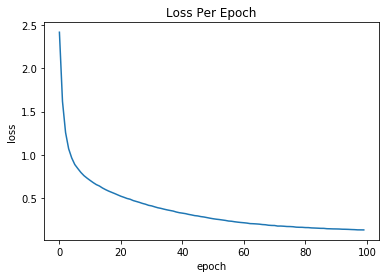

In [43]:
losses = results.results['losses']
epochs = np.arange(len(losses))
plt.title(r'Loss Per Epoch')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(epochs, losses)
plt.show()

### Save embeddings:

In [44]:
import pandas as pd

classes = list(results.results['entity_to_embedding'].keys())
cls_embeds = list(results.results['entity_to_embedding'].values())

df = pd.DataFrame({'classes': classes, 'embeddings': cls_embeds})
df.to_pickle('data/transe/cls_embeddings.pkl')

relations = list(results.results['relation_to_embedding'].keys())
rel_embeds = list(results.results['relation_to_embedding'].values())
df = pd.DataFrame({'relations': relations, 'embeddings': rel_embeds})
df.to_pickle('data/transe/rel_embeddings.pkl')


### Evaluation results on test set:
 * Hits@k, k $\in$ {10, 100}
 * Mean rank
 * ROC AUC

In [45]:
from scipy.stats import rankdata

def load_test_data(data_file, classes, relations):
    data = []
    rel = f'http://interacts'
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'http://{it[0]}'
            id2 = f'http://{it[1]}'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((id1, rel, id2))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc

cls_df = pd.read_pickle('data/transe/cls_embeddings.pkl')
rel_df = pd.read_pickle('data/transe/rel_embeddings.pkl')
classes = {v: k for k, v in enumerate(cls_df['classes'])}
relations = {v: k for k, v in enumerate(rel_df['relations'])}

nb_classes = len(cls_df)
nb_relations = len(rel_df)
embeds_list = cls_df['embeddings'].values
rembeds_list = rel_df['embeddings'].values
size = len(embeds_list[0])
embeds = np.zeros((nb_classes, size), dtype=np.float32)
for i, emb in enumerate(embeds_list):
    embeds[i, :] = emb

proteins = {}
for k, v in classes.items():
    if not k.startswith('<http://purl.obolibrary.org/obo/GO_'):
        proteins[k] = v

prot_index = list(proteins.values())
prot_embeds = embeds[prot_index, :]
prot_dict = {v: k for k, v in enumerate(prot_index)}
    
rsize = len(rembeds_list[0])
rembeds = np.zeros((nb_relations, rsize), dtype=np.float32)
for i, emb in enumerate(rembeds_list):
    rembeds[i, :] = emb

train_data = load_test_data('data/data-train/4932.protein.links.v10.5.txt', classes, relations)
valid_data = load_test_data('data/data-valid/4932.protein.links.v10.5.txt', classes, relations)
trlabels = {}
for c, r, d in train_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000
for c, r, d in valid_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000

test_data = load_test_data('data/data-test/4932.protein.links.v10.5.txt', classes, relations)
top1 = 0
top10 = 0
top100 = 0
mean_rank = 0
ftop1 = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
labels = {}
preds = {}
ranks = {}
franks = {}
eval_data = test_data
n = len(eval_data)
for c, r, d in eval_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in labels:
        labels[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    if r not in preds:
        preds[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.float32)
    labels[r][c, d] = 1
    ec = prot_embeds[c, :]
    er = rembeds[r, :]
    ec += er

    # Compute distance
    dst = np.linalg.norm(prot_embeds - ec.reshape(1, -1), axis=1)
    res = dst.flatten()

    preds[r][c, :] = res
    index = rankdata(res, method='average')
    rank = index[d]
    if rank == 1:
        top1 += 1
    if rank <= 10:
        top10 += 1
    if rank <= 100:
        top100 += 1
    mean_rank += rank
    if rank not in ranks:
        ranks[rank] = 0
    ranks[rank] += 1

    # Filtered rank
    index = rankdata((res * trlabels[r][c, :]), method='average')
    rank = index[d]
    if rank == 1:
        ftop1 += 1
    if rank <= 10:
        ftop10 += 1
    if rank <= 100:
        ftop100 += 1
    fmean_rank += rank

    if rank not in franks:
        franks[rank] = 0
    franks[rank] += 1
top1 /= n
top10 /= n
top100 /= n
mean_rank /= n
ftop1 /= n
ftop10 /= n
ftop100 /= n
fmean_rank /= n

rank_auc = compute_rank_roc(ranks, len(proteins))
frank_auc = compute_rank_roc(franks, len(proteins))

print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')

0.06 0.17 8382.89 0.83
0.08 0.20 8335.63 0.84
